In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
from scipy.interpolate import interp1d

In [3]:
mpk = np.genfromtxt(r'C:/Users/satvi/PhD_thesis/kk.dat')

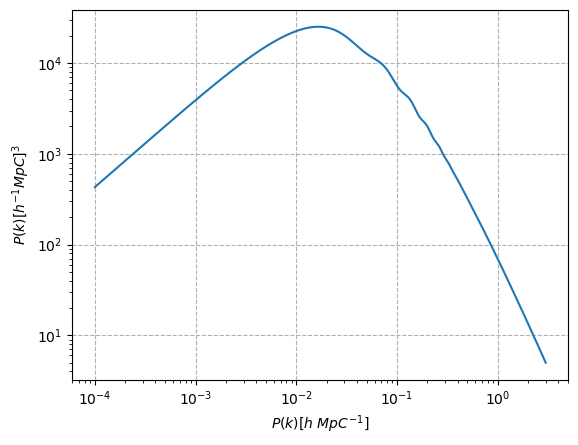

In [4]:
plt.plot(mpk[:,0],mpk[:,1])
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^3$')
plt.xlabel('$P(k) [h~MpC^{-1}]$')
plt.yscale('log')
plt.xscale('log')

In [6]:
interpolation_func = interp1d(mpk[:,0], mpk[:,1], kind='linear')

In [7]:
np.set_printoptions(linewidth=400)
np.set_printoptions(precision=4)
def distance1(length,cx,cy):
    l_by_2 = int(length/2)
    
    x_val = np.linspace(0,l_by_2*np.pi,l_by_2)+2*np.pi  #creating uniform x grid
    
    x_val_fft = np.concatenate([x_val[::-1],-x_val])
    
    xx, yy = np.meshgrid(x_val_fft, x_val_fft, indexing='ij')
    xx = np.roll(xx, shift = -l_by_2+cx, axis=0)
    yy = np.roll(yy, shift = -l_by_2+cy, axis=1)
    
    kxx = 2*np.pi/xx
    kyy = 2*np.pi/yy
    
    dist = np.zeros((length,length))
    for i in range(length):
        for j in range(length):
            dist[i,j] = np.sqrt((xx[i,j])**2 + (yy[i,j])**2)
    #dist = dist + 2*np.pi # to avoid division by zero
    return x_val_fft, kxx,kyy, dist



In [8]:
def pk_whitenoise(length):
    cx = int(length/2)
    cy=cx
    white_noise = np.random.normal(loc=0,scale=1,size=length**2).reshape(length,length)
    
    x_val_fft = distance1(length,cx,cy)[0]
    kxx = distance1(length,cx,cy)[1]
    kyy = distance1(length,cx,cy)[2]
    
    k_grid = np.zeros((length,length))
    
    for i in range(length):
        for j in range(length):
            k_grid[i,j] = np.sqrt(kxx[i,j]**2 + kyy[i,j]**2)
        
    del_k = interpolation_func(k_grid)    #Power spectra values for the k grid           

    white_noise_fft = np.fft.fft2(white_noise,norm='backward')
    
    #convolute in k space

    delta_k_conv = white_noise_fft * np.sqrt(del_k)
    delta_k_conv[0,0] = 0   #setting dc component to zero
    
    return delta_k_conv, k_grid

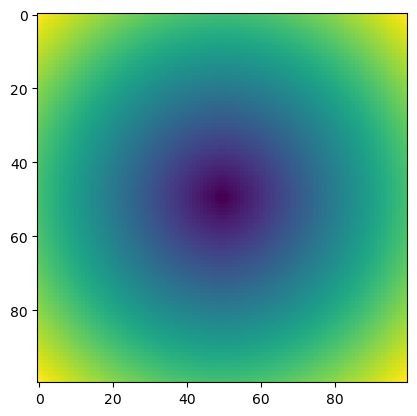

In [9]:
plt.imshow(distance1(100,50,50)[3])
# plt.savefig("example_distance.png")

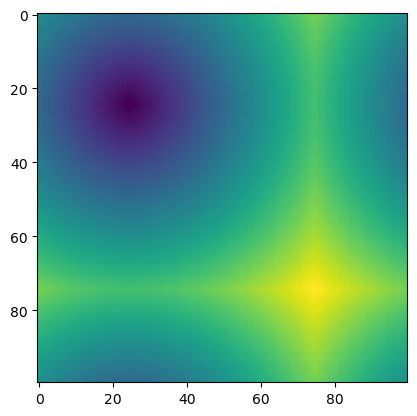

In [10]:
plt.imshow(distance1(100,25,25)[3])

In [49]:
length = 100
delta_k_conv = pk_whitenoise(length)[0]
delta_x_conv = np.fft.ifft2(delta_k_conv)
delta_x_trunc = delta_x_conv    #length is 49 and not 50
delta_x_flat=delta_x_trunc.flatten()
delta_x_flat.shape

(10000,)

In [50]:
# l_by_2 = int(length/2)
# distmax = np.max(distance1(length,l_by_2,l_by_2)[3])
# distmin = np.min(distance1(length,l_by_2,l_by_2)[3])

# bins = int(distmax/distmin)

# pk = np.zeros(bins)
# pk_sample = np.zeros(bins)
# for i in range(length-1):
#     print(i)
#     for j in range(length-1):   #due to truncation of zero row and column
        

#         dist = distance1(length,i,j)[3]
        
#         for m in range(length-1):
#             for n in range(length-1):
#                 f = int(dist[m,n]/distmin)-1
#                 pk[f] = pk[f] + delta_x_trunc[m,n].real * delta_x_trunc[i,j].real
#                 pk_sample[f] = pk_sample[f] + 1

l_by_2 = int(length/2)
distmax = np.max(distance1(length,l_by_2,l_by_2)[3])
distmin = np.min(distance1(length,l_by_2,l_by_2)[3])
distance = distance1(length,l_by_2,l_by_2)[3]
bins = int(distmax/distmin)

pk = np.zeros(bins)
pk_sample = np.zeros(bins)
for i in range(length):
    print(i)
    for j in range(length):   #due to truncation of zero row and column
        
        d = np.roll(np.roll(distance, shift = -l_by_2+i, axis=0),shift = -l_by_2+j, axis=1)
        f = (d.flatten()/distmin).astype(int)-1
        
        for i in range(bins):
            pk[i] = pk[i] + np.sum(delta_x_trunc[i,j].real * delta_x_flat[f==i].real)
            pk_sample[i] = pk_sample[i] + np.sum(f==i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [52]:
xar = np.linspace(distmin*0.5,distmax-distmin/2,bins)
kar = 2*np.pi/xar
mpk = np.genfromtxt(r'C:/Users/satvi/PhD_thesis/kk.dat')
plt.scatter(kar[1:12], np.abs(test[1:12])/(kar[1:12])**2/6.3,s=5)
plt.plot(mpk[:,0],mpk[:,1])
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^2$')
plt.xlabel('$k [h~MpC^{-1}]$')
plt.title("2d from correlation")
# plt.savefig("Pkz_0_2d_kxspace")
plt.xscale('log')
plt.yscale('log')

NameError: name 'test' is not defined

In [ ]:
xar = np.linspace(distmin*0.5,distmax-distmin/2,bins)
# xar = np.linspace(distmin,distmax-distmin/2,bins)
pk_avg = pk/pk_sample

test = np.fft.fft(pk_avg)


In [ ]:
mpk = np.genfromtxt(r'C:/Users/satvi/PhD_thesis/kk.dat')
plt.scatter(2*np.pi/xar[1:], np.abs(test[1:]),s=10)
plt.plot(mpk[:,0],mpk[:,1])
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^2$')
plt.xlabel('$k [h~MpC^{-1}]$')
plt.title("2d from correlation")
# plt.savefig("Pkz_0_2d_kxspace")
plt.xscale('log')
plt.yscale('log')
# plt.savefig("pkz_0correlation2d,")

# 3d correlations

In [14]:
np.set_printoptions(linewidth=400)
np.set_printoptions(precision=4)
def distance3d(length,cx,cy,cz):
    l_by_2 = int(length/2)
    
    x_val = np.linspace(0,l_by_2*np.pi,l_by_2)+1.5*np.pi  #creating uniform x grid
    
    x_val_fft = np.concatenate([x_val[::-1],-x_val])
    
    xx, yy, zz = np.meshgrid(x_val_fft, x_val_fft, x_val_fft, indexing='ij')
    xx = np.roll(xx, shift = -l_by_2+cx, axis=0)
    yy = np.roll(yy, shift = -l_by_2+cy, axis=1)
    zz = np.roll(yy, shift = -l_by_2+cz, axis=2)
    
    kxx = 2*np.pi/xx
    kyy = 2*np.pi/yy
    kzz = 2*np.pi/zz
    
    dist = np.zeros((length,length,length))
    for i in range(length):
        for j in range(length):
            for k in range(length):
                dist[i,j,k] = np.sqrt((xx[i,j,k])**2 + (yy[i,j,k])**2 + zz[i,j,k]**2)
    #dist = dist + 2*np.pi # to avoid division by zero
    return x_val_fft, kxx,kyy, kzz, dist



In [15]:
def pk_whitenoise3d(length):
    cx = int(length/2)
    cy=cx
    cz=cx
    white_noise = np.random.normal(loc=0,scale=1,size=length**3).reshape(length,length,length)
    
    x_val_fft = distance1(length,cx,cy)[0]
    kxx = distance3d(length,cx,cy,cz)[1]
    kyy = distance3d(length,cx,cy,cz)[2]
    kzz = distance3d(length,cx,cy,cz)[3]
    dist= distance3d(length,cx,cy,cz)[4]
    
    k_grid = np.zeros((length,length,length))
    
    for i in range(length):
        for j in range(length):
            for k in range(length):
                k_grid[i,j,k] = np.sqrt(kxx[i,j,k]**2 + kyy[i,j,k]**2 + kzz[i,j,k]**2)
        
    del_k = interpolation_func(k_grid)    #Power spectra values for the k grid           

    white_noise_fft = np.fft.fftn(white_noise,norm='backward')
    
    #convolute in k space

    delta_k_conv = white_noise_fft * np.sqrt(del_k)
    delta_k_conv[0,0,0] = 0   #setting dc component to zero
    
    return delta_k_conv, k_grid

In [19]:
length = 50
l_by_2=int(length/2)
delta_k_conv = pk_whitenoise3d(length)[0]
delta_x_conv = np.fft.ifftn(delta_k_conv)
delta_x_trunc = delta_x_conv[1:,1:,1:]
delta_k_back = np.fft.fftn(delta_x_conv)

In [20]:
# k_val_conv = pk_whitenoise(length)[0][1:,1:]
k_grid = pk_whitenoise3d(length)[1]
    
kgrid_flat = (k_grid).flatten()
deltakconvflat = delta_k_back.flatten()
    
kspace = np.logspace(np.log10(kgrid_flat.min()),np.log10(kgrid_flat.max()),l_by_2)
pk = np.zeros((l_by_2))
for i in range(0,l_by_2-1):
    cond = (kgrid_flat >=kspace[i]) & (kgrid_flat<kspace[i+1])
    pk[i] = (np.abs(deltakconvflat[cond])**2).sum()/len( deltakconvflat[cond] )


C:\Users\satvi\AppData\Local\Temp\ipykernel_13012\2800631248.py:11: RuntimeWarning: invalid value encountered in double_scalars
  pk[i] = (np.abs(deltakconvflat[cond])**2).sum()/len( deltakconvflat[cond] )


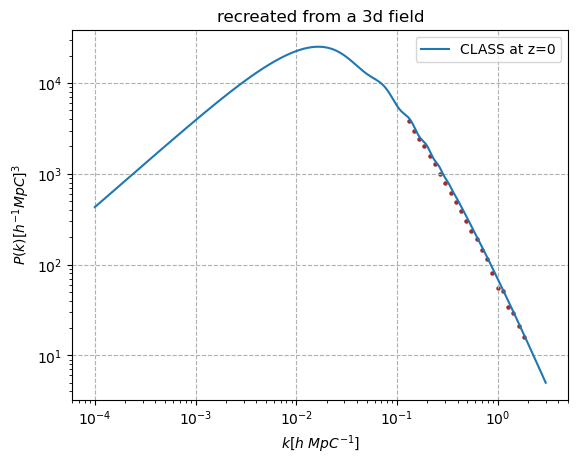

In [23]:
plt.scatter(kspace,pk/length**3,s=5,c='brown')
plt.plot(mpk[:,0],mpk[:,1],label="CLASS at z=0")
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^3$')
plt.xlabel('$k [h~MpC^{-1}]$')

# plt.errorbar(kspace[1:l], pk_mean[1:], yerr=pk_std[1:], fmt='--^', label='Data', linewidth=0.5,markersize=2.0)
plt.title("recreated from a 3d field")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig("Pkz_0_3d_xspace")

In [25]:
delta_k_conv = pk_whitenoise3d(length)[0]
delta_x_conv = np.fft.ifftn(delta_k_conv)
delta_x_trunc = delta_x_conv[1:,1:,1:]    #length is 49 and not 50

In [ ]:
l_by_2 = int(length/2)
distmax = np.max(distance3d(length,l_by_2,l_by_2,l_by_2)[4])
distmin = np.min(distance3d(length,l_by_2,l_by_2,l_by_2)[4])

bins = int(distmax/distmin)

pk = np.zeros(bins)
pk_sample = np.zeros(bins)
for i in range(length-1):
    print(i)
    for j in range(length-1):   #due to truncation of zero row and column
        for k in range(length-1):
        
            dist = distance3d(length,i,j,k)[4]
        
            for m in range(length-1):
                for n in range(length-1):
                    for o in range(length-1):
                        f = int(dist[m,n,o]/distmin)-1
                        pk[f] = pk[f] + delta_x_trunc[m,n,o].real * delta_x_trunc[i,j,o].real
                        pk_sample[f] = pk_sample[f] + 1

0


# Trying to speed up

In [74]:
length = 6
delta_k_conv = pk_whitenoise3d(length)[0]
delta_x_conv = np.fft.ifftn(delta_k_conv)
delta_x_trunc = delta_x_conv    #length is 49 and not 50
delta_x_flat=delta_x_trunc.flatten()

In [84]:
l_by_2 = int(length/2)
distmax = np.max(distance3d(length,l_by_2,l_by_2,l_by_2)[4])
distmin = np.min(distance3d(length,l_by_2,l_by_2,l_by_2)[4])
distance = distance3d(length,l_by_2,l_by_2,l_by_2)[4]
bins = int(distmax/distmin)

pk = np.zeros(bins)
pk_sample = np.zeros(bins)
for i in range(length-1):
    print(i)
    for j in range(length-1):   #due to truncation of zero row and column
        for k in range(length-1):
                
            d = np.roll(np.roll(np.roll(distance, shift = -l_by_2+i, axis=0),shift = -l_by_2+j, axis=1),shift = -l_by_2+k, axis=2)
            f = (d.flatten()/distmin).astype(int)-1
        
            for i in range(bins):
                pk[i] = pk[i] + np.sum(delta_x_trunc[i,j,k].real * delta_x_flat[f==i].real)
                pk_sample[i] = pk_sample[i] + np.sum(f==i)

0
1
2
3
4


array([12000., 12000.,  3000.])

In [65]:
xar = np.linspace(distmin*0.5,distmax-distmin/2,bins)
kar = 2*np.pi/xar
pk_avg = pk/pk_sample
test = np.fft.fft(pk_avg)

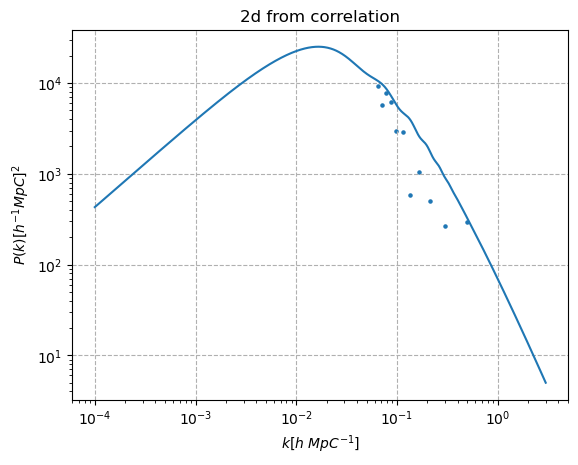

In [73]:
mpk = np.genfromtxt(r'C:/Users/satvi/PhD_thesis/kk.dat')
plt.scatter(kar[1:12], np.abs(test[1:12])*bins/(kar[1:12])**2,s=5)
plt.plot(mpk[:,0],mpk[:,1])
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^2$')
plt.xlabel('$k [h~MpC^{-1}]$')
plt.title("2d from correlation")
# plt.savefig("Pkz_0_2d_kxspace")
plt.xscale('log')
plt.yscale('log')
# plt.savefig("pkz_0correlation2d,")

In [70]:
bins

17